# Implementation of Variational AutoEncoder (VAE)

     VAE from "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.)
    
     Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)
     
     Author-email:  mskang@handong.edu

     python and pytorch version: python=3.7, pytorch=1.3.1

In [ ]:
!pip install tqdm

In [ ]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

# 배치 사이즈: 한 번의 반복(iteration)에 학습할 데이터의 개수
batch_size = 100
# 입력 차원: MNIST 이미지는 28x28 픽셀이므로 이를 평탄화(flatten)하면 784 차원이 됨
x_dim  = 784
# 은닉층 차원: 인코더와 디코더의 중간 레이어 노드 수
hidden_dim = 400
# 잠재 변수(Latent Vector) 차원: 데이터를 압축할 z 벡터의 차원
latent_dim = 200
# 학습률 (Learning Rate)
lr = 1e-3
# 학습 에포크 수 (전체 데이터셋을 몇 번 반복 학습할지)
epochs = 30

###    Step 1. Load (or download) Dataset

MNIST 데이터셋이란?
내용: 0부터 9까지의 손글씨 숫자 이미지 데이터입니다.

크기: 각 이미지는 가로 28픽셀, 세로 28픽셀(28x28) 크기의 흑백 이미지입니다.

학습용: 60,000장

테스트용: 10,000장

2차원 이미지(28x28)를 **1차원 벡터(784)**로 쭉 펼쳐서(Flatten) 사용
x_dim = 784 (28 * 28 = 784)

"""`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

Args:
    root (str or ``pathlib.Path``): Root directory of dataset where ``MNIST/raw/train-images-idx3-ubyte``
        and  ``MNIST/raw/t10k-images-idx3-ubyte`` exist.
    train (bool, optional): If True, creates dataset from ``train-images-idx3-ubyte``,
        otherwise from ``t10k-images-idx3-ubyte``.

    transform (callable, optional): A function/transform that  takes in a PIL image
        and returns a transformed version. E.g, ``transforms.RandomCrop``

    target_transform (callable, optional): A function/transform that takes in the
        target and transforms it.
        
    download (bool, optional): If True, downloads the dataset from the internet and
        puts it in root directory. If dataset is already downloaded, it is not
        downloaded again.


In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 
# 1. 학습용 데이터셋 (train=True)
# 모델이 정답(Label)을 보며 가중치를 수정합니다.
train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
# 2. 테스트용 데이터셋 (train=False)
# 모델 학습에는 절대 관여하지 않고, 나중에 점수 매길 때만 씁니다.
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)
# 3. 로더 설정 (shuffle 옵션 차이)
# 학습 때는 순서를 외우지 못하게 섞습니다(True).
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
# 테스트 때는 섞을 필요가 없습니다(False).
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

100%|██████████| 9.91M/9.91M [00:12<00:00, 763kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 139kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 695kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.2MB/s]


### Step 2. Define our model: Variational AutoEncoder (VAE)

In [ ]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [ ]:
m = nn.Linear(20, 30)
input = torch.randn(128, 20)
output = m(input)
print("1111=>{0}",output.size())
torch.Size([128, 30])

1111=>{0} torch.Size([128, 30])


torch.Size([128, 30])

$$h = x \times \underbrace{\text{W}^T}_{\text{저장된 값}} + \underbrace{b}_{\text{저장된 값}}$$


In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        # 압축된 잠재 변수를 받아서 첫번째 은닉층으로 확장합니다.(압축파일을 풀기 시작하는 단계)
        # 기계를 만들 때, 내부에 W와 b를 생성해서 품고 있습니다.
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        # 층이 깊을 수록 더 복장하고 정교한 이미지를 그려낼 수 있기 때문에 추가 됨
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        #은닉층의 정보를 원본 이미지 크기로 변환하는 단계
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        #LeakyReLU 음수로 내려갈 경우 기존 값에서 20% 로 줄요서 표현
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        # MNIST 손글씨 데이터는 흑백이미지라서 0, 또는 1로 표현해야함
        # BCEL(Binary Cross Entropy) Loss 는
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    # *** 핵심 기능: Reparameterization Trick ***
    # 목적: 확률 분포에서 샘플링을 하면서도, 역전파(Backpropagation)가 가능하게 만드는 기법
    def reparameterization(self, mean, var):
        # 1. 표준 정규 분포(평균 0, 표준편차 1)에서 무작위 노이즈(epsilon)를 뽑습니다.
        # randn_like(var): var와 같은 크기(shape)의 노이즈 행렬 생성
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        

        # 2. 샘플링 공식: z = 평균 + 표준편차 * 노이즈
        # 이렇게 하면 무작위성(epsilon)은 고정된 상수로 취급되어, mean과 var에 대해 미분이 가능해집니다.        
        # 일차 방정식으로 변경
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        # 1. [인코딩] 이미지를 입력받아 잠재 공간의 '평균'과 '로그 분산'을 추론합니다.        
        mean, log_var = self.Encoder(x)
        
        # 2. [표준편차 변환]
        # 신경망은 '분산(Variance)'이 아닌 '로그 분산(Log Variance)'을 출력하므로 변환이 필요합니다.
        # 수식: std = exp(0.5 * log_var)  (이유: sqrt(exp(x)) == exp(0.5 * x))
        # 여기서 두 번째 인자로 들어가는 값은 '표준편차(sigma)'입니다.        
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)

        # 3. [디코딩] 추출한 잠재 변수(z)를 사용해 이미지를 복원합니다.        
        x_hat            = self.Decoder(z)
        # 4. 복원된 이미지, 평균, 로그 분산을 모두 반환합니다.
        # (평균과 로그 분산은 나중에 KLD Loss 계산에 쓰입니다)        
        return x_hat, mean, log_var

In [1]:
# 값을 확인해 보자
# 모델이 관리하고 있는 '새끼 모델'들의 이름표 출력
print("=== 등록된 서브 모델들 ===")
for name, module in model.named_children():
    print(f"이름: {name} | 종류: {module}")

print("\n=== 수집된 파라미터들 (일부) ===")
# parameters()가 가져오는 것들의 이름 확인
for name, param in model.named_parameters():
    print(name) 
    # 결과 예시: 
    # Encoder.FC_input.weight
    # Encoder.FC_input.bias
    # ...

=== 등록된 서브 모델들 ===


NameError: name 'model' is not defined

In [ ]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [8]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [ ]:
print("Start training VAE...")
# 1. 모델을 학습 모드로 전환
# (Dropout이나 Batch Normalization 같은 기능들이 학습용으로 작동하게 함)
model.train()
# 2. 에포크(Epoch) 반복: 전체 데이터셋을 몇 번 훑어볼 것인지
for epoch in range(epochs):
    overall_loss = 0

    # 3. 배치(Batch) 단위로 데이터 가져오기
    # train_loader가 데이터를 batch_size(100개)만큼씩 묶어서 줍니다.
    # x: 이미지 데이터, _: 정답 라벨 (VAE는 비지도 학습이라 정답 라벨을 안 씁니다)    
    for batch_idx, (x, _) in enumerate(train_loader):
        # 4. 데이터 모양 변경 (Flatten)
        # (100, 1, 28, 28) -> (100, 784)로 쫙 펴줍니다.
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        # 6. 기울기(Gradient) 초기화 [중요!]
        # 이전 배치를 학습할 때 계산된 기울기가 남아있으면 안 되므로 0으로 리셋합니다.
        optimizer.zero_grad()

        # 7. 순전파 (Forward Pass)
        # 모델에 데이터를 넣어서 결과(복원 이미지, 평균, 로그 분산)를 얻습니다.
        x_hat, mean, log_var = model(x)

        # 8. 오차(Loss) 계산
        # 원본(x)과 복원본(x_hat)이 얼마나 다른지, 분포가 얼마나 정규분포와 다른지 계산합니다.        
        loss = loss_function(x, x_hat, mean, log_var)
        
        # 9. 결과 출력을 위해 오차 누적 (학습에는 영향 없음)
        overall_loss += loss.item()
        

        # 10. 역전파 (Backward Pass) [핵심]
        # 오차(loss)를 줄이는 방향으로 각 파라미터들의 미분값(기울기)을 계산합니다.        
        loss.backward()
        
        # 11. 가중치 업데이트 (Weight Update)
        # 계산된 기울기를 바탕으로 모델의 파라미터(W, b)를 실제로 수정합니다.        
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  174.24136353558012
	Epoch 2 complete! 	Average Loss:  129.16599880008349
	Epoch 3 complete! 	Average Loss:  117.22480824160058
	Epoch 4 complete! 	Average Loss:  112.79729288397328
	Epoch 5 complete! 	Average Loss:  110.03729369913397
	Epoch 6 complete! 	Average Loss:  108.43441841545805
	Epoch 7 complete! 	Average Loss:  107.29039678761478
	Epoch 8 complete! 	Average Loss:  106.35341565369366
	Epoch 9 complete! 	Average Loss:  105.49594074433952
	Epoch 10 complete! 	Average Loss:  104.93347147589733
	Epoch 11 complete! 	Average Loss:  104.30452614709411
	Epoch 12 complete! 	Average Loss:  103.741640625
	Epoch 13 complete! 	Average Loss:  103.44557796522851
	Epoch 14 complete! 	Average Loss:  103.00708702329403
	Epoch 15 complete! 	Average Loss:  102.75427411571368
	Epoch 16 complete! 	Average Loss:  102.51056541175396
	Epoch 17 complete! 	Average Loss:  102.16912295231636
	Epoch 18 complete! 	Average Loss:  101.97493653158911
	E

### Step 5. Generate images from test dataset

In [11]:
!pip install matplotlib 

   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------- 8.3/8.3 MB 48.7 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 39.1 MB/s  0:00:00

   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   -------------------------- ------------- 4/6 [contourpy]
   --------------------------------- ------ 5/6 [matplotlib]
   --------------------------------- ------ 5/6 [matplotlib]
   --------------------------------- ------ 5/6 [ma

In [12]:
import matplotlib.pyplot as plt

In [ ]:
# 평가하자
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:03<?, ?it/s]


In [14]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

In [ ]:
# 테스트의 문구를 확인해 보자
# 1. 디코더가 모델 안에 있는지 확인
print("--- 디코더의 정체 ---")
print(model.Decoder) 
# 출력: Decoder( (FC_hidden): Linear(...) ... ) -> 모델 안에 잘 들어있습니다.

print("\n--- 가중치(Weight)의 정체 ---")
# 2. 디코더의 마지막 층(이미지 만드는 층)의 가중치 꺼내보기
# FC_output 레이어 안의 'weight'라는 변수에 저장되어 있습니다.
output_weights = model.Decoder.FC_output.weight

print(f"가중치 크기(Shape): {output_weights.shape}") 
# 출력: torch.Size([784, 400]) -> 400개 입력을 784개 픽셀로 바꾸는 행렬

print("\n--- 실제 가중치 값 (일부) ---")
print(output_weights)
# 출력: tensor([[ 0.0123, -0.5432, ...], ...]) -> 학습된 숫자들이 보입니다!

### 테스트 원본 이미지 출력
#### show_image(x, idx=0) 

### 테스트 복원 이미지 출력
#### show_image(x_hat, idx=0)

#### 비슷하게 나오는 것을 확인함

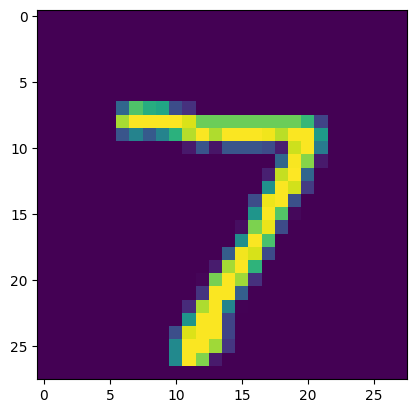

In [29]:
show_image(x, idx=0)

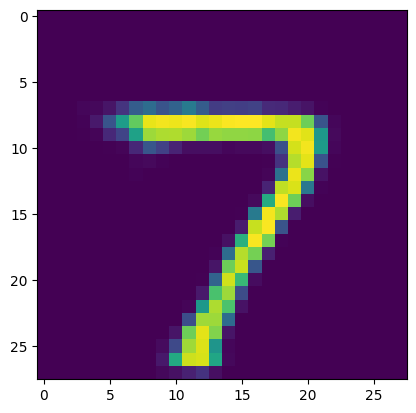

In [30]:
show_image(x_hat, idx=0)

### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [ ]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [ ]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')


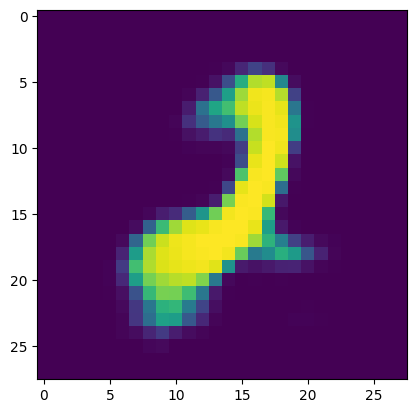

In [33]:
show_image(generated_images, idx=12)

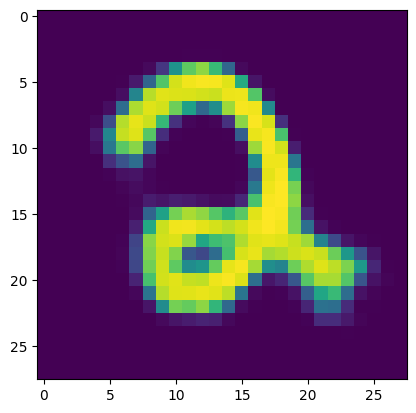

In [34]:
show_image(generated_images, idx=0)

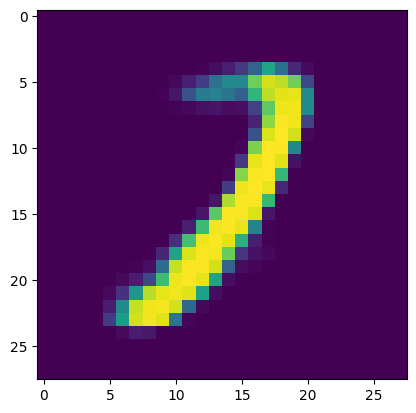

In [35]:
show_image(generated_images, idx=1)

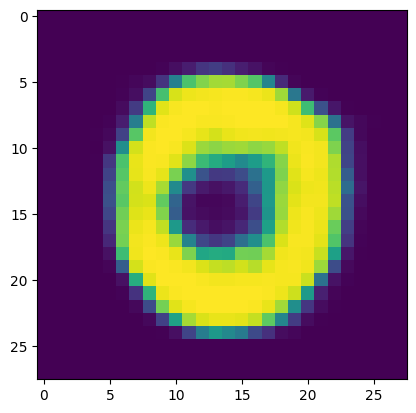

In [36]:
show_image(generated_images, idx=10)

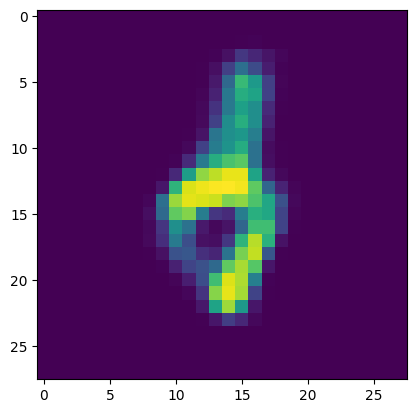

In [37]:
show_image(generated_images, idx=20)

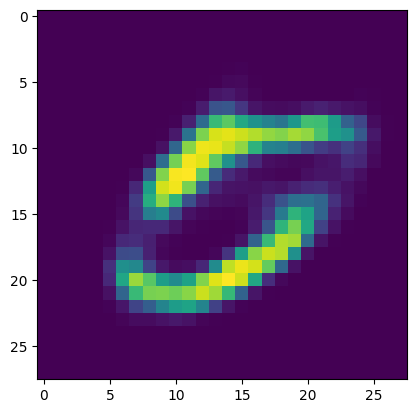

In [38]:
show_image(generated_images, idx=50)